# Import modules

In [1]:
import networkx as nx
import graph_tool.all as gt
# from graph_tool.all import vertex_percolation

import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import random

color = sns.color_palette()
sns.set_style("dark")
sns.set_style("whitegrid")
%matplotlib inline

/home/amidsilence/anaconda2/lib/python2.7/site-packages/graph_tool/draw/cairo_draw.py:1480: RuntimeWarning: Error importing Gtk module: No module named gi; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


---
# Data

In [2]:
raw_data_gml = "./dataset/as-22july06.gml"
network_name = "as-22july06"

data_gml = "./dataset/as-22july06-new.gml"

# Function

# Task

---
### Preprocessing

In [3]:
import subprocess
subprocess.call("sed 'N;s/\s\+\[/ \[/g;P;D' <"+ raw_data_gml + " >"+ data_gml, shell=True)

0

In [4]:
# Load network for networkx
G = nx.read_gml(data_gml)
node_list = G.nodes()
edge_list = G.edges()

# Load network for graph_tool
g = gt.load_graph(data_gml)

In [5]:
# Network properties
print "Network name: " + network_name
print "Type: " + ("Directed" if nx.is_directed(G) else "Undirected")
print "Nodes:", len(node_list)
print "Edges:", len(edge_list)

Network name: as-22july06
Type: Undirected
Nodes: 22963
Edges: 48436


In [6]:
# # Network statistics
# nx.density(G)
# nx.average_clustering(G, trials=1000)

---
### 1. Percolation with uniform removal of nodes

In [38]:
random_removal_list = list(g.vertices())
repeat = 20
sizes_list = [] # To store the sizes of every simulation

for _ in range(repeat):
    np.random.shuffle(random_removal_list)
    sizes, comp = gt.vertex_percolation(g, random_removal_list)
    sizes_list.append(sizes)
    
average_sizes = np.mean(sizes_list,axis=0)

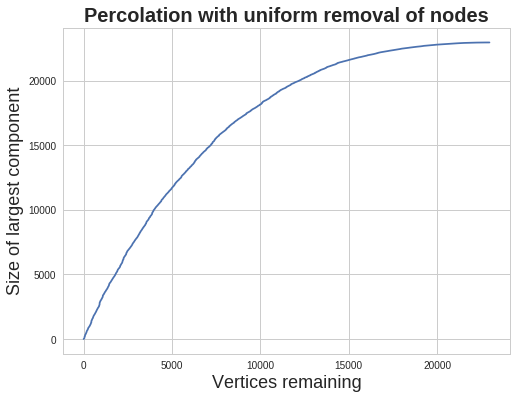

In [39]:
plt.figure(figsize=(8,6))
plt.plot(average_sizes)
plt.title("Percolation with uniform removal of nodes", fontsize=20, fontweight='bold')
plt.xlabel("Vertices remaining", fontsize=18)
plt.ylabel("Size of largest component", fontsize=18)

---
### 2. Percolation with non-uniform removal

In [46]:
targeted_removal_list = sorted([v for v in g.vertices()], key=lambda v: v.out_degree())
sizes2, comp = gt.vertex_percolation(g, targeted_removal_list)


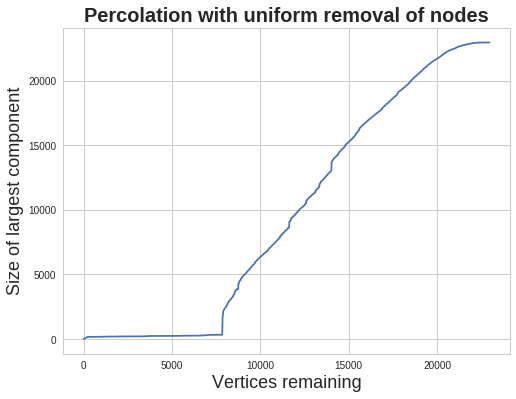

In [47]:
plt.figure(figsize=(8,6))
plt.plot(sizes2)
plt.title("Percolation with uniform removal of nodes", fontsize=20, fontweight='bold')
plt.xlabel("Vertices remaining", fontsize=18)
plt.ylabel("Size of largest component", fontsize=18)

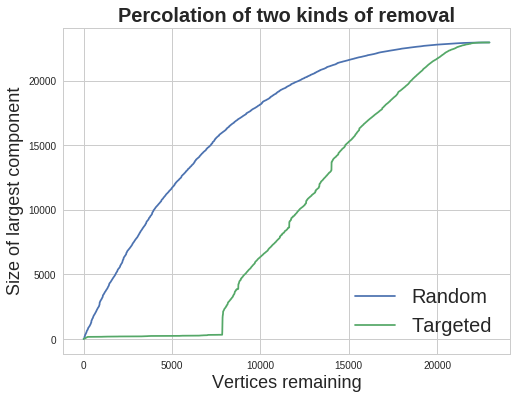

In [58]:
plt.figure(figsize=(8,6))
plt.plot(average_sizes, label="Random")
plt.plot(sizes2, label="Targeted")
plt.title("Percolation of two kinds of removal", fontsize=20, fontweight='bold')
plt.xlabel("Vertices remaining", fontsize=18)
plt.ylabel("Size of largest component", fontsize=18)
plt.legend(loc="lower right",prop={'size':20})

---
### 3. Other removal approaches

In [69]:
# Remove vetices in descending order based on eigenvector centrality
largest_eigen, eigen_cent_map = gt.eigenvector(g)
eigen_cent_removal_list = sorted(g.vertices(), key=lambda v: eigen_cent_map[v])
sizes3, comp = gt.vertex_percolation(g, eigen_cent_removal_list)


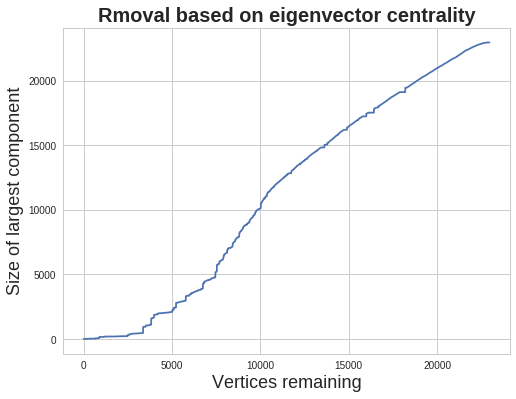

In [73]:
plt.figure(figsize=(8,6))
plt.plot(sizes3)
plt.title("Rmoval based on eigenvector centrality", fontsize=20, fontweight='bold')
plt.xlabel("Vertices remaining", fontsize=18)
plt.ylabel("Size of largest component", fontsize=18)

In [36]:
# 
g_copy = g.copy()
max_deg_removal_list = []

for i in range(len(list(g_copy.vertices()))):
    max_deg_v = max(g_copy.vertices(), key=lambda v: v.out_degree())
    max_deg_removal_list.append(g.vertex_index[max_deg_v])
    g_copy.remove_vertex(max_deg_v)

In [37]:
print len(list(g.vertices()))
print len(max_deg_removal_list)
# remove_vertex

22963
22963


In [38]:
test = max_deg_removal_list[::-1]
sizes4, comp = gt.vertex_percolation(g, test)

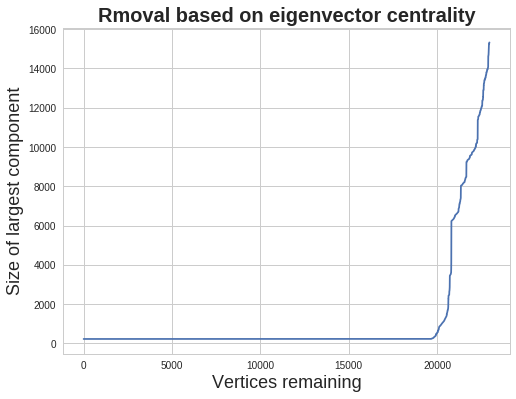

In [39]:
plt.figure(figsize=(8,6))
plt.plot(sizes4)
plt.title("Removal based on eigenvector centrality", fontsize=20, fontweight='bold')
plt.xlabel("Vertices remaining", fontsize=18)
plt.ylabel("Size of largest component", fontsize=18)

---
### 4. Epidemic simulation 1

In [48]:
def getInfected(node, beta, node_state_dict, type="normal", targeted_list=None):
    ''' 
        Use numpy random to generate a number within [0,1) to decide whether the infection happens for a given probability beta. 
        If argument "type" is "special", then the targeted nodes would get 100% infected.
        
        Return: 
            A bool value to indicate whether the input node get infected this time.
    '''
    if type=="special":
        if node in targeted_list and node_state_dict[node]==0:
            return True

    return (np.random.random()<=beta) and (node_state_dict[node]==0)

def countInfectious(state_dict):
    '''
        Since the value is 1 for infectious nodes. Just sum them up to get the total number of infected nodes. 
    '''
    return sum(state_dict.values())

def simulate(beta, epochs=10, type="normal", targeted_list=None):
    
    epidimics_data_records = [] # To store the epidimics_data_record to compute the average trend
    total_simulation_times = 100
    
    for i in range(epochs):

        epidimics_data_record = []
        state_dict = {} # 0 for Susceptible, 1 for Infectious
        candidate_nodes = []

        # Initialize the state dict for nodes to Susceptible
        for node in node_list:
            state_dict[node] = 0

        # Random choose a node as the first infected node and change its state
        secure_random = random.SystemRandom()
        first_infected_node = secure_random.choice(node_list)
        state_dict[first_infected_node] = 1
        epidimics_data_record.append(1)

        # Add its neightbors to potential infectee candidates
        neighbors = G.neighbors(first_infected_node)
        candidate_nodes.extend(neighbors)

        # Start simulation over virus spread
        for j in range(total_simulation_times):

            new_infected_nodes = []
            for node in candidate_nodes:
                if getInfected(node,beta,state_dict, type, targeted_list):
                    state_dict[node] = 1
                    new_infected_nodes.append(node)

            # Remove nodes that got infected from candidate list
            candidate_nodes = [node for node in candidate_nodes if node not in new_infected_nodes]

            # Add new candidates to candidate list. New candidates come from the neighbor of newly infected ones.
            for node in new_infected_nodes:
                potential_neighbors = [ node for node in G.neighbors(node) if state_dict[node]==0 ]
                candidate_nodes.extend(potential_neighbors)

            epidimics_data_record.append( countInfectious(state_dict) )

        epidimics_data_records.append(epidimics_data_record)

    average_epi_data = np.mean(epidimics_data_records,axis=0)
    return average_epi_data


In [37]:
beta_epidata_dict = {}
beta = 0.01

for i in range(4):
    
    epidimics_data = simulate(beta)
    beta_epidata_dict[beta] = epidimics_data
    
    beta += 0.01 


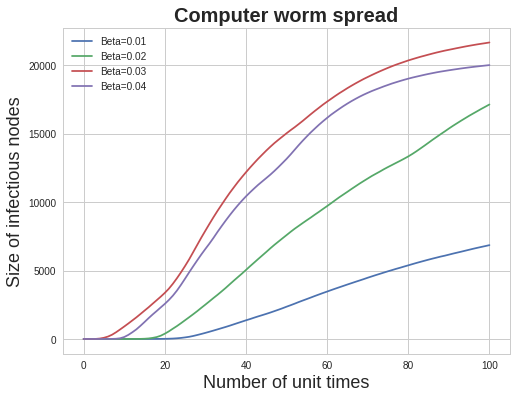

In [39]:
plt.figure(figsize=(8,6))

for beta in sorted(beta_epidata_dict):
    plt.plot(beta_epidata_dict[beta], label="Beta={0}".format(beta))
    
plt.title("Computer worm spread", fontsize=20, fontweight='bold')
plt.xlabel("Number of unit times", fontsize=18)
plt.ylabel("Size of infectious nodes", fontsize=18)
plt.legend()

---
### 5. Epidemic simulation 2
With super infectious power
beta=1

In [41]:
targeted_nums = [1,5,10,20,100]

sorted_node_list = sorted(node_list, key=lambda n:G.degree(n),reverse=True)
targeted_node_lists = [sorted_node_list[:num] for num in targeted_nums ]

targeted_betas = [(0.02*len(edge_list) - num)/(len(edge_list) - num)  for num in targeted_nums ]


In [55]:
epidimics_data_0 = simulate(0.02)

In [49]:
targeted_num_epidata_dict = {}

for idx, num in enumerate(targeted_nums):
    
    epidimics_data = simulate(targeted_betas[idx], type="special", targeted_list=targeted_node_lists[idx])
    targeted_num_epidata_dict[num] = epidimics_data
    


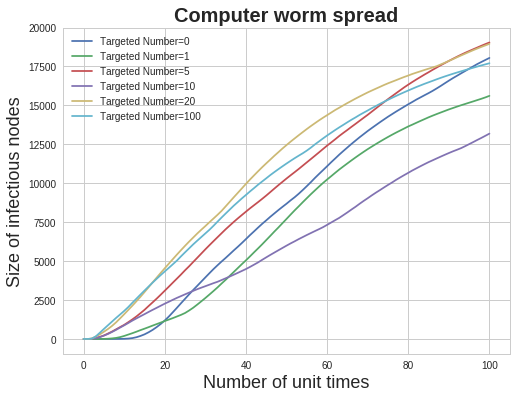

In [56]:
plt.figure(figsize=(8,6))

plt.plot(epidimics_data_0, label="Targeted Number={0}".format(0))

for num in sorted(targeted_nums):
    plt.plot(targeted_num_epidata_dict[num], label="Targeted Number={0}".format(num))
    
plt.title("Computer worm spread", fontsize=20, fontweight='bold')
plt.xlabel("Number of unit times", fontsize=18)
plt.ylabel("Size of infectious nodes", fontsize=18)
plt.legend()

In [23]:
print len(node_list)

22963
